In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2023-11-22 16:59:32.839856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


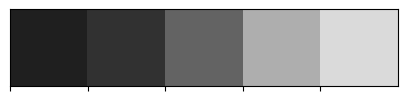

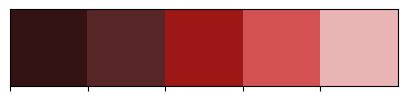

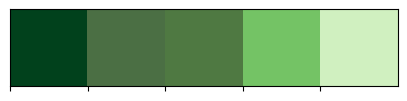

In [2]:
#odredi boje
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_green)

In [3]:
#odredi kategorije
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [4]:
#odredi 2 niza, x za svem yslike, y za sve nazive. Pa zatim prodji 
#kroz sve foldere i stavi sve djuture u ta dva niza
# '/Users/user/Desktop/Kaggle data sets/brain_tumor/Data'

X_train = []
Y_train = []
image_size = 200

for i in labels:
    folderPath = os.path.join('/Users/user/Desktop/Kaggle data sets/brain_tumor/Data', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img_name = os.path.join(folderPath, j)
        img = cv2.imread(img_name)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)


for i in labels:
    folderPath = os.path.join('/Users/user/Desktop/Kaggle data sets/brain_tumor/Data', 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img_name = os.path.join(folderPath, j)
        img = cv2.imread(img_name)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)


100%|███████████████████████████████████████████| 74/74 [00:01<00:00, 60.05it/s]


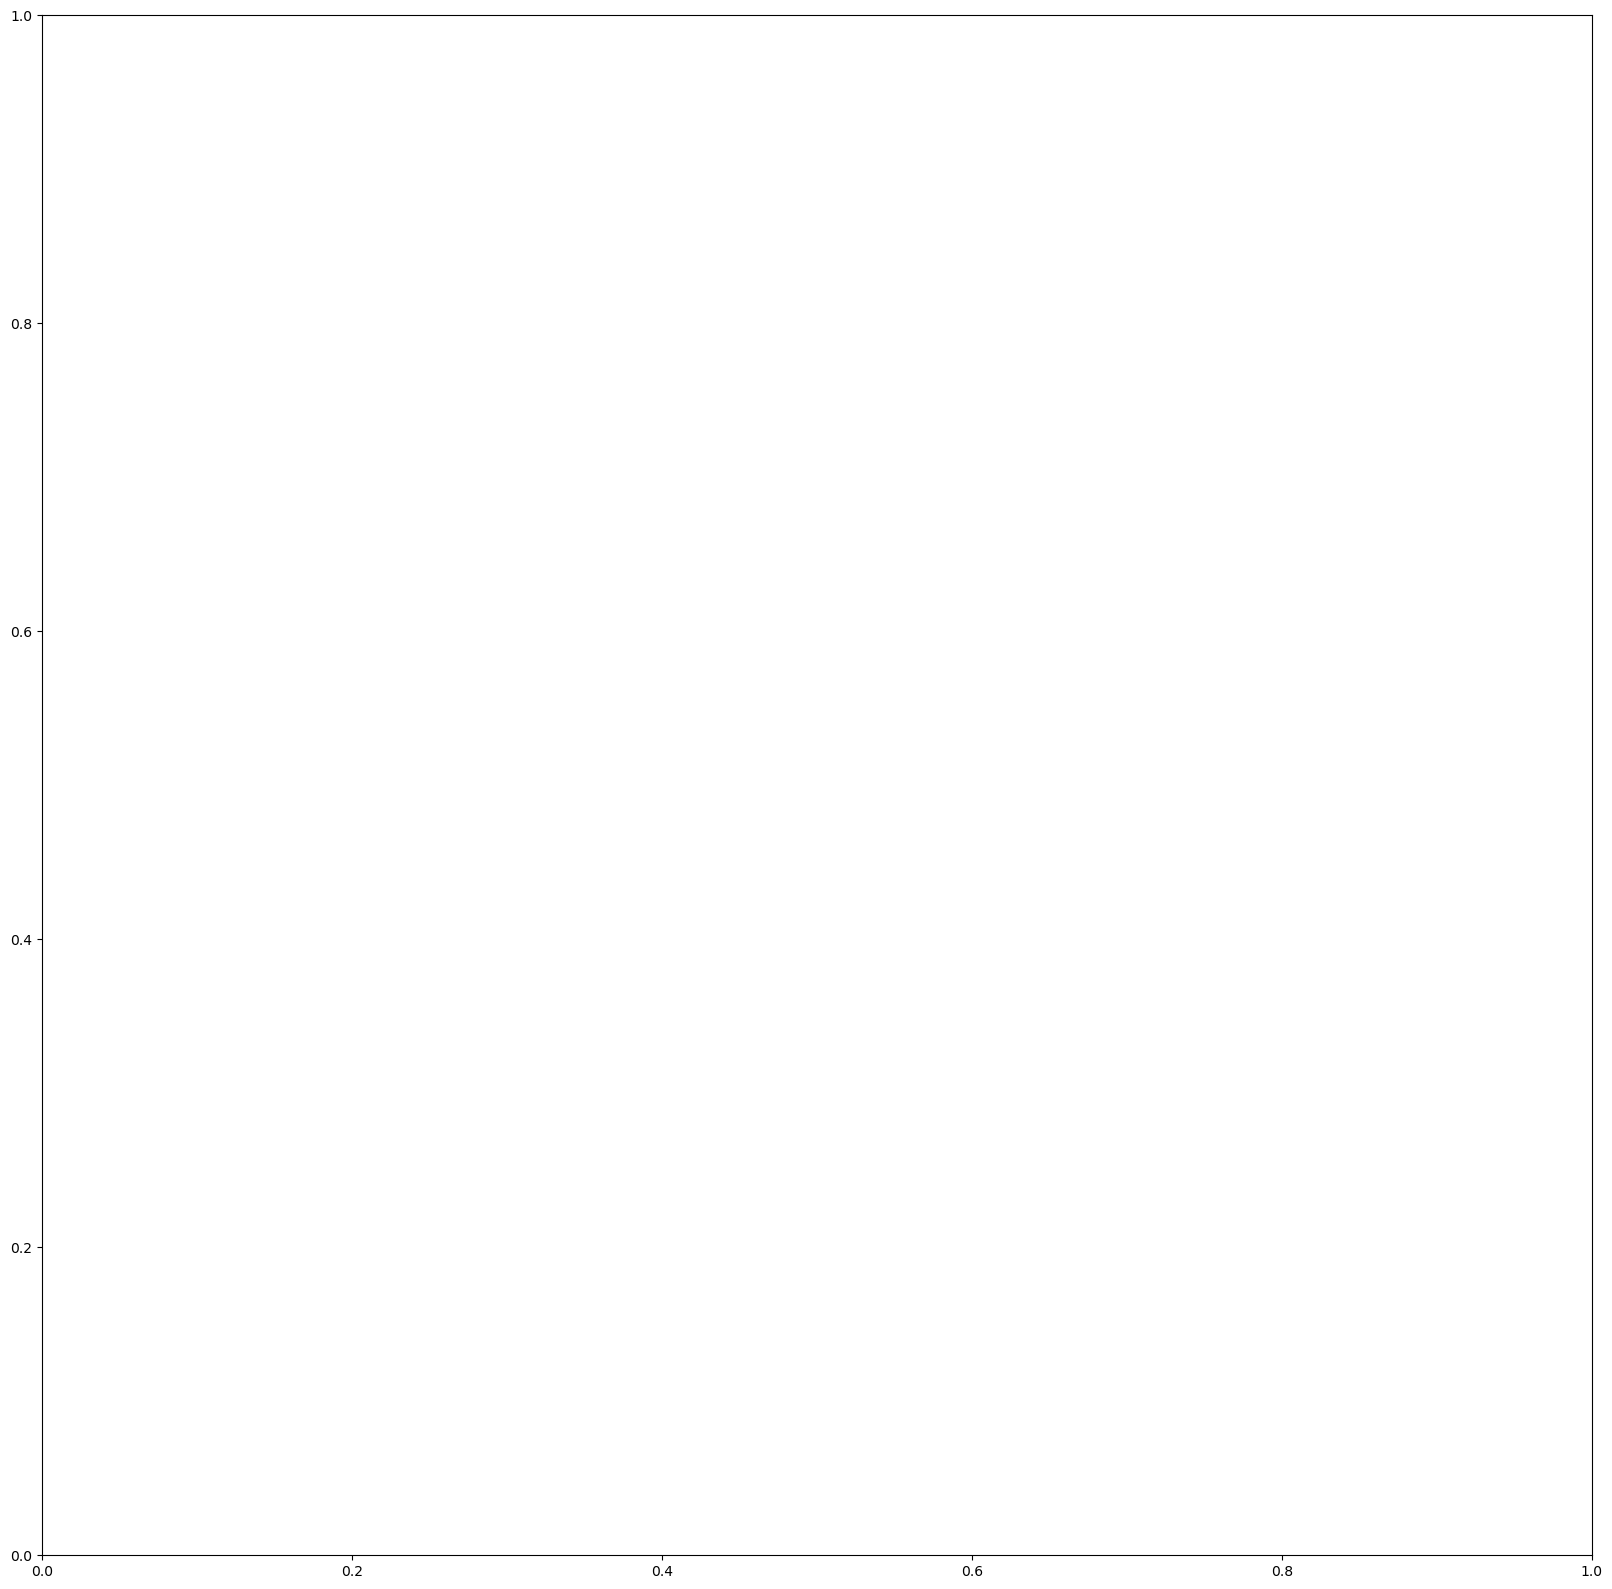

In [5]:
#uzmi i vidi da li si ti do dobro uradio i pogledaj primere za tvoj datasetb

k = 0
fig, ax = plt.subplots(1,1, figsize=(20, 20))
#fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
 #            fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)




In [1]:
print(1+1)

2


In [ ]:
podeli data set u training i testing 

In [ ]:
onda uradi one hot encoding 